# Import Library

In [3]:
import argparse
import gradio as gr
import torch
from PIL import Image
import re
import transformers
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np

from donut import DonutModel

c:\Users\indri\.conda\envs\dss_donut\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
c:\Users\indri\.conda\envs\dss_donut\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
# hidde logs
transformers.logging.disable_default_handler()

# load our model from Hugging Face
processor_sroie = DonutProcessor.from_pretrained("philschmid/donut-base-sroie")
model_sroie = VisionEncoderDecoderModel.from_pretrained("philschmid/donut-base-sroie")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


## Read dataset

In [11]:
import os
from PIL import Image

# folder path
dir_path = r'C:\Users\indri\Documents\Algoritma\Data Science Series\Bismillah DSS Donuts - Fiqey Indriati\data_input\custom'

# list to store files
res = []
# labs = []
# Iterate directory
for file in os.listdir(dir_path):
    # check only text files
    if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
        res.append(file)
    # elif file.endswith('.txt'):
        # labs.append(file)
print(res)
# print(labs)

['img20170406164316.jpg', 'loko.jpg', 'loko2.jpg']


In [12]:
images = []
for filename in res:
    images.append(Image.open('data_input/custom/' + filename))

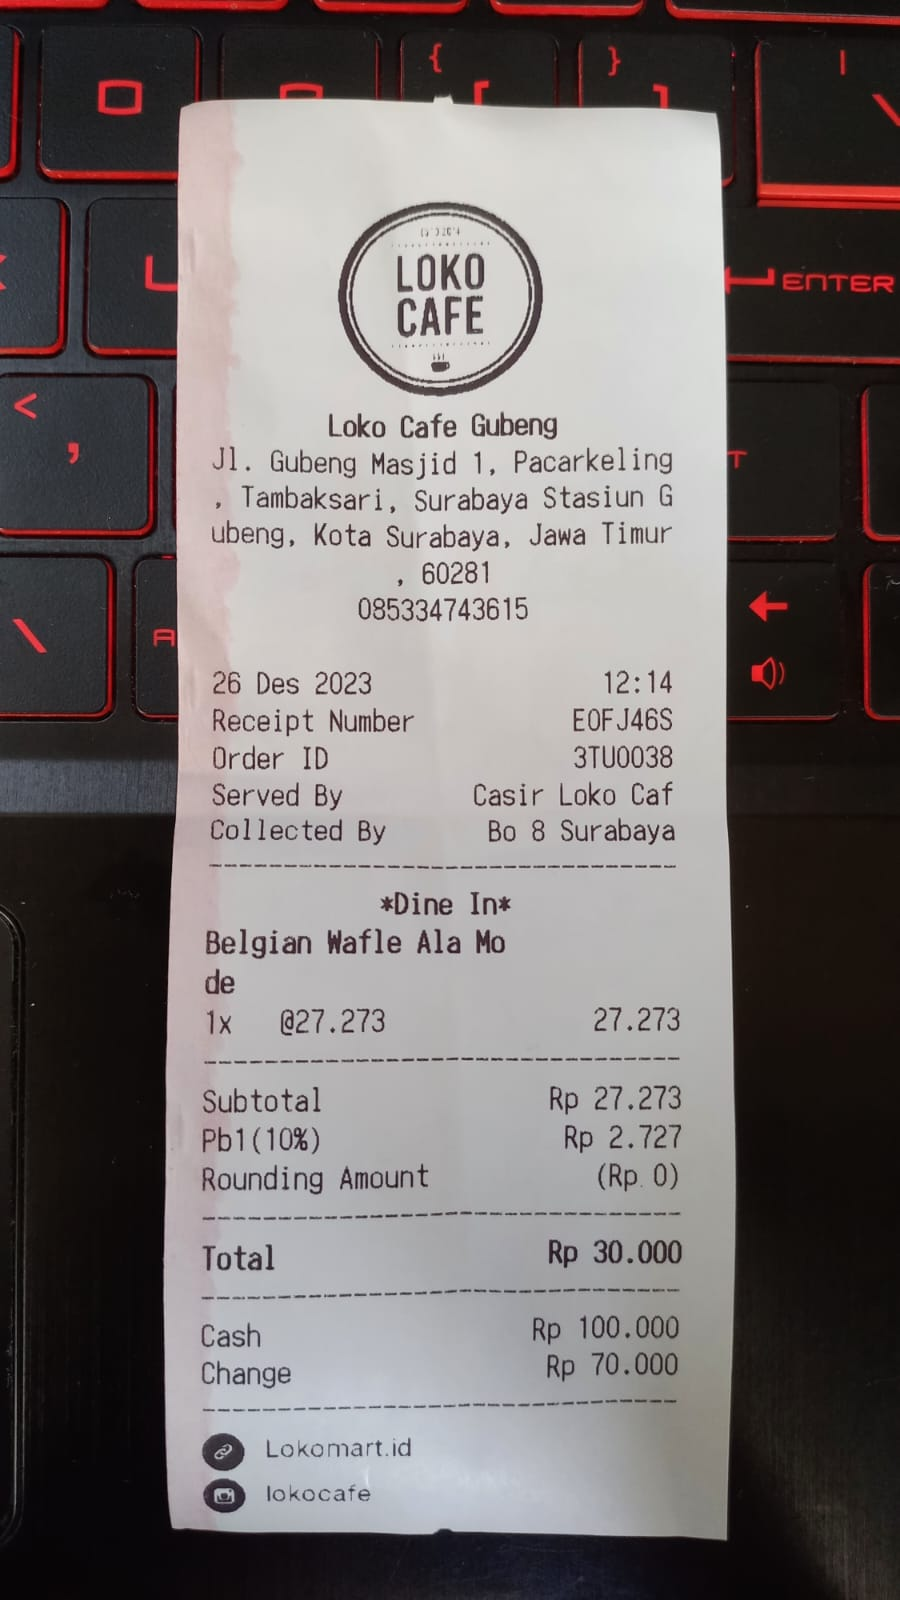

In [16]:
# print(labels[5])
images[1]

## Prepare using processor

We prepare the image for the model using `DonutProcessor`.

In [29]:
pixel_values = processor(images[1], return_tensors="pt").pixel_values
print(pixel_values.shape)

torch.Size([1, 3, 1280, 960])


## Generate

Finally, we let the model autoregressively generate the structured data.

In [19]:
# details output
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

# set model device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        
        # modify parameters
        early_stopping=True,
        num_beams=2,
        output_scores=True,
    )

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

<s_menu><s_nm> LOKO CAFE</s_nm><s_num> LOKO Cafe Gubeng</s_nm><s_num> Jl. Gubeng Masjid 1, Pacarkeling</s_num><s_unitprice> Surabaya Stasiun G</s_nm><s_num>,</s_num><s_unitprice> 60281</s_unitprice><s_cnt>,</s_cnt><s_price>,</s_price><sep/><s_nm> Tambaksari, Surabaya Stasiun G</s_nm><s_num>,</s_num><s_unitprice> 60281</s_unitprice><s_cnt>,</s_unitprice><s_cnt> 26</s_cnt><s_price> 12:14</s_price><sep/><s_nm> Receipt Number</s_nm><s_num> EOFJ46S</s_num><s_price> 3TU0038</s_price><sep/><s_nm> Order ID</s_nm><s_num> Berved By Casir Loko Cafe</s_nm><s_num> Collected By</s_nm><s_num> Bo 8</s_num><s_price> Surabaya</s_price><s_sub><s_nm> *Dine In*</s_nm></s_sub><sep/><s_nm> Belgian Wafle Ala Mo</s_nm><s_num> de</s_nm><s_num> *Dine</s_nm><s_num> *Dine</s_num><s_unitprice> @27.273</s_unitprice><s_cnt> 1x</s_cnt><s_price> 27.273</s_price></s_menu><s_sub_total><s_subtotal_price> Rp 27.273</s_subtotal_price><s_tax_price> 2.727</s_tax_price><s_etc> Rp 0)</s_etc></s_sub_total><s_total><s_total_price

## Convert to JSON

We can convert the generated sequence to JSON if required:

In [27]:
processor.token2json(sequence)

{'menu': [{'nm': 'LOKO CAFE',
   'unitprice': {'num': ','},
   'cnt': ',',
   'price': ','},
  {'nm': 'Tambaksari, Surabaya Stasiun G',
   'num': ',',
   'unitprice': '60281',
   'price': '12:14'},
  {'nm': 'Receipt Number', 'num': 'EOFJ46S', 'price': '3TU0038'},
  {'nm': 'Order ID', 'price': 'Surabaya', 'sub': {'nm': '*Dine In*'}},
  {'nm': 'Belgian Wafle Ala Mo',
   'unitprice': '@27.273',
   'cnt': '1x',
   'price': '27.273'}],
 'sub_total': {'subtotal_price': 'Rp 27.273',
  'tax_price': '2.727',
  'etc': 'Rp 0)'},
 'total': {'total_price': 'Rp 30.000',
  'cashprice': 'Rp 100.000',
  'changeprice': 'Rp 70.000'}}

### Make Custom Function for Generate Output

In [39]:
task_prompt = f"<s_cord-v2>"

def adjust_demo_process(input_img):
    global model, task_prompt, task_prompt_sroie
    pixel_values = processor(input_img, return_tensors="pt").pixel_values
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

    # set model device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
        
        # modify parameters
        early_stopping=True,
        num_beams=2,
        output_scores=True,
    )
    
    # data post-processing
    sequence = processor.batch_decode(outputs.sequences)[0]
    sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
    print(sequence)

    # convert sequence to json
    output = processor.token2json(sequence)
    # output = pd.DataFrame.from_dict(output)
    # ===================================================

    return output

In [ ]:
# date output
# details output

def run_prediction_date_company(input_img, model=model_sroie, processor=processor_sroie, img_processor=processor):
    # prepare inputs
    task_prompt_sroie = "<s>"
    pixel_values = img_processor(input_img, return_tensors="pt").pixel_values
    decoder_input_ids = processor.tokenizer(task_prompt_sroie, add_special_tokens=False, return_tensors="pt")["input_ids"]
    
    # set model device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    return prediction

run_prediction_date_company(images[1])

In [40]:
import pandas as pd

In [41]:
preds = []
for img in images[:3]:
    out = adjust_demo_process(img)
    out['company_date'] = run_prediction_date_company(img)
    preds.append(out)

<s_menu><s_nm> TOKO KOMPUTER</s_nm><s_unitprice> Purwadad - Subang</s_nm><s_unitprice> 06/04/2017 16:41</s_unitprice><s_cnt> Jl.Raya</s_cnt><s_price> 16:41</s_price><sep/><s_nm> Telp.081321411703</s_nm><s_unitprice> 500</s_unitprice><s_cnt> x 1</s_cnt><s_price> 500</s_price><sep/><s_nm> Kopi Kapal api</s_nm><s_unitprice> 2.000</s_unitprice><s_cnt> x 1</s_cnt><s_price> 2.000</s_price><sep/><s_nm> Mister Kentang Goreng</s_nm><s_unitprice> 2.000</s_unitprice><s_cnt> x 1</s_cnt><s_price> 2.000</s_price><sep/><s_nm> Sari Roti</s_nm><s_unitprice> 4.000</s_unitprice><s_cnt> x 1</s_cnt><s_price> 4.000</s_price></s_menu><s_sub_total><s_subtotal_price> Rp 8.500</s_subtotal_price><s_tax_price> Rp 10.000</s_tax_price></s_sub_total><s_total><s_total_price> Rp 1.500</s_total_price><s_cashprice> kasir. ujang</s_cashprice><s_changeprice> No.06042017044019</s_changeprice></s_total>
<s_menu><s_nm> LOKO CAFE</s_nm><s_num> LOKO Cafe Gubeng</s_nm><s_num> Jl. Gubeng Masjid 1, Pacarkeling</s_num><s_unitprice

In [42]:
import pandas as pd
df_preds = pd.DataFrame.from_dict(preds)
df_preds.head()

,menu,sub_total,total,company_date
0,"[{'nm': 'TOKO KOMPUTER', 'cnt': 'Jl.Raya', 'pr...","{'subtotal_price': 'Rp 8.500', 'tax_price': 'R...","{'total_price': 'Rp 1.500', 'cashprice': 'kasi...","{'total': '8.500', 'date': '500', 'company': '..."
1,"[{'nm': 'LOKO CAFE', 'unitprice': {'num': ','}...","{'subtotal_price': 'Rp 27.273', 'tax_price': '...","{'total_price': 'Rp 30.000', 'cashprice': 'Rp ...","{'total': '27.273', 'date': '26 DES 2023', 'co..."
2,"[{'nm': 'LOKO CAFE', 'price': 'CAFE'}, {'nm': ...","{'subtotal_price': 'Rp 20.909', 'tax_price': '...","{'total_price': 'Rp 23.000', 'cashprice': 'Rp ...","{'total': '20.90', 'date': '26 DES 2023', 'com..."


In [43]:
df_preds['company_date'][0].keys()

dict_keys(['total', 'date', 'company', 'address'])

In [44]:
df_preds

,menu,sub_total,total,company_date
0,"[{'nm': 'TOKO KOMPUTER', 'cnt': 'Jl.Raya', 'pr...","{'subtotal_price': 'Rp 8.500', 'tax_price': 'R...","{'total_price': 'Rp 1.500', 'cashprice': 'kasi...","{'total': '8.500', 'date': '500', 'company': '..."
1,"[{'nm': 'LOKO CAFE', 'unitprice': {'num': ','}...","{'subtotal_price': 'Rp 27.273', 'tax_price': '...","{'total_price': 'Rp 30.000', 'cashprice': 'Rp ...","{'total': '27.273', 'date': '26 DES 2023', 'co..."
2,"[{'nm': 'LOKO CAFE', 'price': 'CAFE'}, {'nm': ...","{'subtotal_price': 'Rp 20.909', 'tax_price': '...","{'total_price': 'Rp 23.000', 'cashprice': 'Rp ...","{'total': '20.90', 'date': '26 DES 2023', 'com..."


In [33]:
# df_preds[['menu', 'total']].to_csv('data_input/receipt_raw.csv', index=False)

In [45]:
df_preds.isna().sum()

menu            0
sub_total       0
total           0
company_date    0
dtype: int64

In [46]:
# pick only total_price
df_preds['total_price'] = df_preds['total'].apply(lambda x: [v for k, v in x.items() if k == 'total_price'])

In [47]:
# pick only tax_price
df_preds['tax_price'] = df_preds['sub_total'].apply(lambda x: [v for k, v in x.items() if k == 'tax_price'])

In [48]:
# pick only company, date
df_preds['company'] = df_preds['company_date'].apply(lambda x: [v for k, v in x.items() if k == 'company'])
df_preds['date'] = df_preds['company_date'].apply(lambda x: [v for k, v in x.items() if k == 'date'])

In [49]:
df_preds

,menu,sub_total,total,company_date,total_price,tax_price,company,date
0,"[{'nm': 'TOKO KOMPUTER', 'cnt': 'Jl.Raya', 'pr...","{'subtotal_price': 'Rp 8.500', 'tax_price': 'R...","{'total_price': 'Rp 1.500', 'cashprice': 'kasi...","{'total': '8.500', 'date': '500', 'company': '...",[Rp 1.500],[Rp 10.000],[TOKO KOMPUTER],[500]
1,"[{'nm': 'LOKO CAFE', 'unitprice': {'num': ','}...","{'subtotal_price': 'Rp 27.273', 'tax_price': '...","{'total_price': 'Rp 30.000', 'cashprice': 'Rp ...","{'total': '27.273', 'date': '26 DES 2023', 'co...",[Rp 30.000],[2.727],[LOKO],[26 DES 2023]
2,"[{'nm': 'LOKO CAFE', 'price': 'CAFE'}, {'nm': ...","{'subtotal_price': 'Rp 20.909', 'tax_price': '...","{'total_price': 'Rp 23.000', 'cashprice': 'Rp ...","{'total': '20.90', 'date': '26 DES 2023', 'com...",[Rp 23.000],"[Rp 2,091]","[LOKO CAFE GUBENG JL. GUBNG MASJID 1, PACARKEING]",[26 DES 2023]


In [50]:
df_preds.loc[0,]['menu']

[{'nm': 'TOKO KOMPUTER', 'cnt': 'Jl.Raya', 'price': '16:41'},
 {'nm': 'Telp.081321411703', 'unitprice': '500', 'cnt': 'x 1', 'price': '500'},
 {'nm': 'Kopi Kapal api',
  'unitprice': '2.000',
  'cnt': 'x 1',
  'price': '2.000'},
 {'nm': 'Mister Kentang Goreng',
  'unitprice': '2.000',
  'cnt': 'x 1',
  'price': '2.000'},
 {'nm': 'Sari Roti', 'unitprice': '4.000', 'cnt': 'x 1', 'price': '4.000'}]

In [51]:
df = pd.DataFrame(columns=['receipt_id', 'nm', 'cnt', 'price', 'total_price', 'tax_price', 'date', 'company'])

# Mengonversi kolom-kolom harga dan jumlah menjadi tipe data numerik
for index, row in df_preds.iterrows():
    if 'list' in str(type(row['menu'])):
        for menu in row['menu']:
            new_row = {}
            for key in menu.keys():
                new_row[key] = menu[key]
            new_row['total_price'] = row['total_price']
            new_row['tax_price'] = row['tax_price']
            new_row['company'] = row['company']
            new_row['date'] = row['date']
            new_row['receipt_id'] = res[index].split('.')[0]
            df.loc[len(df)] = new_row
    else:
        new_row = {}
        for key in row['menu'].keys():
            new_row[key] = row['menu'][key]
        new_row['total_price'] = row['total_price']
        new_row['tax_price'] = row['tax_price']
        new_row['company'] = row['company']
        new_row['date'] = row['date']
        new_row['receipt_id'] = res[index].split('.')[0]
        df.loc[len(df)] = new_row
df


,receipt_id,nm,cnt,price,total_price,tax_price,date,company
0,img20170406164316,TOKO KOMPUTER,Jl.Raya,16:41,[Rp 1.500],[Rp 10.000],[500],[TOKO KOMPUTER]
1,img20170406164316,Telp.081321411703,x 1,500,[Rp 1.500],[Rp 10.000],[500],[TOKO KOMPUTER]
2,img20170406164316,Kopi Kapal api,x 1,2.000,[Rp 1.500],[Rp 10.000],[500],[TOKO KOMPUTER]
3,img20170406164316,Mister Kentang Goreng,x 1,2.000,[Rp 1.500],[Rp 10.000],[500],[TOKO KOMPUTER]
4,img20170406164316,Sari Roti,x 1,4.000,[Rp 1.500],[Rp 10.000],[500],[TOKO KOMPUTER]
5,loko,LOKO CAFE,",",",",[Rp 30.000],[2.727],[26 DES 2023],[LOKO]
6,loko,"Tambaksari, Surabaya Stasiun G",NaN,12:14,[Rp 30.000],[2.727],[26 DES 2023],[LOKO]
7,loko,Receipt Number,NaN,3TU0038,[Rp 30.000],[2.727],[26 DES 2023],[LOKO]
8,loko,Order ID,NaN,Surabaya,[Rp 30.000],[2.727],[26 DES 2023],[LOKO]
9,loko,Belgian Wafle Ala Mo,1x,27.273,[Rp 30.000],[2.727],[26 DES 2023],[LOKO]


In [52]:
for index, row in df.iterrows():
    drop = True
    row['price'] = row['price'].replace(".", "").replace(",", "").replace("Rp", "").replace(" ", "")
    if row['price'].isnumeric():
        drop = False
    print(index, drop, row['price'])
    # elif ':' in row['price']:
        # drop = True
    
    if drop:
        df.drop(index, inplace=True)

0 True 16:41
1 False 500
2 False 2000
3 False 2000
4 False 4000
5 True 
6 True 12:14
7 True 3TU0038
8 True Surabaya
9 False 27273
10 True CAFE
11 False 08533473615
12 True 13:21
13 True 3TU0051
14 True Surabaya
15 False 20909


In [53]:
df

,receipt_id,nm,cnt,price,total_price,tax_price,date,company
1,img20170406164316,Telp.081321411703,x 1,500,[Rp 1.500],[Rp 10.000],[500],[TOKO KOMPUTER]
2,img20170406164316,Kopi Kapal api,x 1,2.000,[Rp 1.500],[Rp 10.000],[500],[TOKO KOMPUTER]
3,img20170406164316,Mister Kentang Goreng,x 1,2.000,[Rp 1.500],[Rp 10.000],[500],[TOKO KOMPUTER]
4,img20170406164316,Sari Roti,x 1,4.000,[Rp 1.500],[Rp 10.000],[500],[TOKO KOMPUTER]
9,loko,Belgian Wafle Ala Mo,1x,27.273,[Rp 30.000],[2.727],[26 DES 2023],[LOKO]
11,loko2,". Tambaksari, Surabaya Stasiun G",NaN,08533473615,[Rp 23.000],"[Rp 2,091]",[26 DES 2023],"[LOKO CAFE GUBENG JL. GUBNG MASJID 1, PACARKEING]"
15,loko2,Special Mie Goreng B,1x,20.909,[Rp 23.000],"[Rp 2,091]",[26 DES 2023],"[LOKO CAFE GUBENG JL. GUBNG MASJID 1, PACARKEING]"


In [176]:
# df.to_csv('data_input/receipt_raw.csv')

In [54]:
def pull_out(x):
    price = ''
    if len(x) > 0:
        price = str(x[0])
    else:
        price = '0'
    return price
df['total_price'] = df['total_price'].apply(lambda x: pull_out(x))

In [55]:
df['company'] = df['company'].apply(lambda x: pull_out(x))
df['date'] = df['date'].apply(lambda x: pull_out(x))

In [56]:
df['tax_price'] = df['tax_price'].apply(lambda x: pull_out(x))

In [57]:
def clean_price(x):
    if x != '':
        price = x.replace(".", "").replace(",", "").replace("Rp", "").replace(" ", "")
    else:
        price = ''
    print(price)
    return int(price)
df['price'] = df['price'].apply(lambda x: clean_price(str(x)))

500
2000
2000
4000
27273
08533473615
20909


In [58]:
df['total_price'] = df['total_price'].apply(lambda x: clean_price(x))
df['tax_price'] = df['tax_price'].apply(lambda x: clean_price(x))

1500
1500
1500
1500
30000
23000
23000
10000
10000
10000
10000
2727
2091
2091


In [59]:
import math
def clean_cnt(x):
    cnt = 0
    if x is not None:
        cnt = float(str(x).replace(" ", "").replace("x", "").replace("X", "").replace("]",""))
    return cnt
    
df['cnt'] = df['cnt'].apply(lambda x: clean_cnt(x))

In [81]:
df = df[df['receipt_id'] != 'img20170406164316'][~df['cnt'].isnull()]

C:\Users\indri\AppData\Local\Temp\ipykernel_1656\1839654998.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df['receipt_id'] != 'img20170406164316'][~df['cnt'].isnull()]


In [82]:
import locale
locale.setlocale(locale.LC_ALL, 'id_ID')

'id_ID'

In [83]:
df['date'] = pd.to_datetime(df['date'], format='%d %b %Y')

In [84]:
df['cnt'].fillna(1, inplace=True)

In [85]:
def to_lower(x):
    return x.lower()
    
df['nm'] = df['nm'].apply(lambda x: to_lower(x))

In [86]:
df['nm'] = df['nm'].astype('category')
df['nm'].nunique()

2

In [87]:
df = df.rename(axis=1, mapper={'nm':'item_name',
                        'cnt': 'count'})

In [88]:
df

,receipt_id,item_name,count,price,total_price,tax_price,date,company
9,loko,belgian wafle ala mo,1.0,27273,30000,2727,2023-12-26,LOKO
15,loko2,special mie goreng b,1.0,20909,23000,2091,2023-12-26,"LOKO CAFE GUBENG JL. GUBNG MASJID 1, PACARKEING"


In [89]:
df.to_csv('data_input/receipt_postprosessed2.csv', index=False)